# Analysis of Generated DNF data
This notebook collects and analyses experiment results that are run on the generated DNF dataset.

In [1]:
# Collect imports
from typing import Dict
from pprint import pprint
import json

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.tracking import MlflowClient

import utils.analysis
import utils.clingo

np.set_printoptions(suppress=True, precision=5, linewidth=120)

In [2]:
# Setup mlflow client
mlclient = MlflowClient(tracking_uri="http://localhost:8888") # Emptry string for local
exp_list = [x.name for x in mlclient.list_experiments()]
print(exp_list)

['gendnf-full-20210412-180710']


## Aggregate Experiment Results
We will look at aggregate metric performances of runs in a given experiment.

- Compare best run for rule learning with symbolic learners.
- Show training curves

In [3]:
# Explore experiment and run data
experiment_name = "gendnf-full-20210411-174308"
experiment_name = exp_list[-1]
mlexp = mlclient.get_experiment_by_name(experiment_name)
print(mlexp)

<Experiment: artifact_location='/homes/nuric/phd/pix2rule/data/artifacts/2', experiment_id='2', lifecycle_stage='active', name='gendnf-full-20210412-180710', tags={}>


In [4]:
# Load experiment data, this includes metrics and parameters
exp_data = utils.analysis.collect_experiment_data(experiment_name, mlclient)
exp_data.columns

Index(['epoch', 'train_loss', 'train_acc', 'validation_loss', 'validation_acc',
       'test_loss', 'test_acc', 'time', 'train_dnf_layer/success_threshold',
       'run_id', 'config_json', 'seq_length', 'seq_seq_symbols', 'seq_tasks',
       'seq_train_size', 'seq_test_split', 'seq_gen_size', 'seq_batch_size',
       'seq_one_hot_labels', 'relsgame_tasks', 'relsgame_train_size',
       'relsgame_validation_size', 'relsgame_test_size', 'relsgame_batch_size',
       'relsgame_output_type', 'relsgame_with_augmentation',
       'relsgame_noise_stddev', 'relsgame_rng_seed', 'gendnf_num_objects',
       'gendnf_num_nullary', 'gendnf_num_unary', 'gendnf_num_binary',
       'gendnf_num_variables', 'gendnf_num_conjuncts', 'gendnf_target_arity',
       'gendnf_gen_size', 'gendnf_train_size', 'gendnf_validation_size',
       'gendnf_test_size', 'gendnf_batch_size', 'gendnf_noise_stddev',
       'gendnf_rng_seed', 'gendnf_return_numpy', 'dataset_name',
       'dnf_image_classifier_image_layer_name

In [5]:
# For our differentiable rule learning, we have X runs per rule
# and there are R many rules (one for each seed) for each difficulty giving X*R*D many runs
df = exp_data[exp_data['train_type'] == 'deep'][['run_id', 'gendnf_difficulty', 'gendnf_rng_seed', 'run_count']]
df.drop_duplicates(inplace=True)
df.set_index('run_id', inplace=True)
# We will collect the pruning information which contains the final results for each run
run_ids = df.index.values
def load_run_json(run_id: str, fname: str,):
    """Load a run artifact json with specified file name."""
    fpath = mlclient.download_artifacts(run_id, fname)
    with open(fpath) as jsonfile:
        run_json = json.load(jsonfile)
    run_json['run_id'] = run_id
    return run_json
run_jsons = [load_run_json(ridx, "pruning_info.json") for ridx in run_ids]
assert len(run_jsons) == df.index.size, "Not all runs have a output json."
run_df = pd.DataFrame(run_jsons)
run_df.set_index('run_id', inplace=True)
# Filter only needed columns
acc_or_loss_cols = [c for c in run_df.columns.values if not 'kernel' in c]
run_df = run_df[acc_or_loss_cols]
# Join parameters and output dataframes
df = df.join(run_df)
df
        

,gendnf_difficulty,gendnf_rng_seed,run_count,validation_preprune_loss,validation_preprune_acc,test_preprune_loss,test_preprune_acc,validation_pruned_loss,validation_pruned_acc,test_pruned_loss,...,prune_count,validation_threshold_loss,validation_threshold_acc,test_threshold_loss,test_threshold_acc,threshold_prune_count,validation_thresholded_pruned_loss,validation_thresholded_pruned_acc,test_thresholded_pruned_loss,test_thresholded_pruned_acc
run_id,,,,,,,,,,,,,,,,,,,,,
e17b9958729e4cd296b1d2a197675e1f,medium,30,3,0.001236,1.0,0.001236,1.0,0.004766,1.000,0.164981,...,136,2.966508,0.506,2.948507,0.509,79,0.308468,0.949,0.242470,0.960
e9e461d2e7474c2d8e473633d75b638b,easy,16,0,0.001238,1.0,0.001241,1.0,0.001238,1.000,0.001238,...,23,0.002476,1.000,0.002476,1.000,0,0.002476,1.000,0.002476,1.000
358f722877d44bbdbe283ab4991a506a,easy,32,3,0.001237,1.0,0.001237,1.0,0.001239,1.000,0.001239,...,20,0.002476,1.000,0.002476,1.000,0,0.002476,1.000,0.002476,1.000
9d787d3947934a90b3ad88ec23fb0ee0,hard,27,0,0.001236,1.0,0.001241,1.0,0.134999,0.998,0.455974,...,173,2.918579,0.514,2.960581,0.507,181,2.060373,0.677,2.120321,0.673
ce5280aea5824171b3bbba74294385a8,medium,30,0,0.001236,1.0,0.001236,1.0,0.103248,0.998,0.296870,...,129,2.954508,0.508,2.984509,0.503,86,0.284469,0.953,0.326468,0.946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ce7cfe74dcec4fe9987cd008412ee5e1,easy,5,4,0.187168,1.0,0.180756,1.0,0.187426,1.000,0.180759,...,17,3.098492,0.484,3.134492,0.478,2,0.248406,0.959,0.266413,0.956
f7433fa996974b16bc5d72020e947b07,hard,30,1,0.001235,1.0,0.001239,1.0,0.140609,0.998,0.522736,...,194,2.960546,0.507,2.954545,0.508,168,1.808279,0.715,1.832250,0.713
6d0c95d266b84b8285a6164f99a94607,easy,30,4,0.001290,1.0,0.001290,1.0,0.001318,1.000,0.001314,...,17,0.002476,1.000,0.002476,1.000,0,0.002476,1.000,0.002476,1.000


In [6]:
# Since symbolic learners are deterministic and return the optimal result, we will take the best
# out of 5 runs for each rule in each difficulty, but just to ensure that the results are consistent
# let's look at the 5 runs for each rule first
df.groupby(['gendnf_difficulty', 'gendnf_rng_seed'])['test_preprune_acc'].describe()

count    mean       std    min    25%  \
gendnf_difficulty gendnf_rng_seed                                          
easy              3                  5.0  0.9490  0.023917  0.919  0.934   
                  5                  5.0  1.0000  0.000000  1.000  1.000   
                  16                 5.0  1.0000  0.000000  1.000  1.000   
                  21                 5.0  0.9952  0.004382  0.992  0.992   
                  27                 5.0  1.0000  0.000000  1.000  1.000   
                  30                 5.0  0.9654  0.049151  0.895  0.932   
                  32                 5.0  0.9862  0.030858  0.931  1.000   
hard              3                  5.0  0.9996  0.000548  0.999  0.999   
                  5                  5.0  0.9996  0.000894  0.998  1.000   
                  16                 5.0  0.9998  0.000447  0.999  1.000   
                  21                 5.0  1.0000  0.000000  1.000  1.000   
                  27                 5.0  0.9954  0.009182  0.979  0.999   
                  30                 5.0  1.0000  0.000000  1.000  1.000   
                  32                 5.0  0.9998  0.000447  0.999  1.000   
medium            3                  5.0  1.0000  0.000000  1.000  1.000   
                  5                  5.0  0.9998  0.000447  0.999  1.000   
                  16                 5.0  1.0000  0.000000  1.000  1.000   
                  21                 5.0  0.9998  0.000447  0.999  1.000   
                  27                 5.0  0.9998  0.000447  0.999  1.000   
                  30                 5.0  0.9998  0.000447  0.999  1.000   
                  32                 5.0  0.9996  0.000894  0.998  1.000   

                                     50%    75%    max  
gendnf_difficulty gendnf_rng_seed                       
easy              3                0.954  0.956  0.982  
                  5                1.000  1.000  1.000  
                  16               1.000  1.000  1.000  
                  21               0.992  1.000  1.000  
                  27               1.000  1.000  1.000  
                  30               1.000  1.000  1.000  
                  32               1.000  1.000  1.000  
hard              3                1.000  1.000  1.000  
                  5                1.000  1.000  1.000  
                  16               1.000  1.000  1.000  
                  21               1.000  1.000  1.000  
                  27               0.999  1.000  1.000  
                  30               1.000  1.000  1.000  
                  32               1.000  1.000  1.000  
medium            3                1.000  1.000  1.000  
                  5                1.000  1.000  1.000  
                  16               1.000  1.000  1.000  
                  21               1.000  1.000  1.000  
                  27               1.000  1.000  1.000  
                  30               1.000  1.000  1.000  
                  32               1.000  1.000  1.000

(0.5, 1.05)

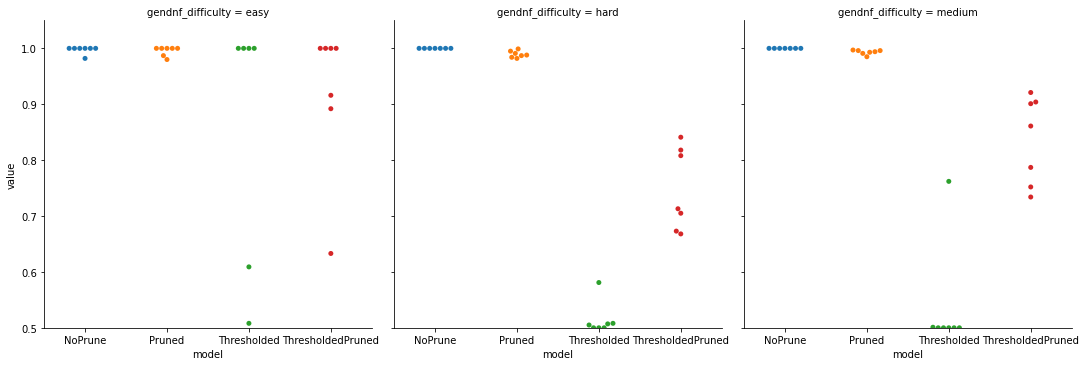

In [7]:
# Take the best run out of 5 based on validation loss
best_run_ids = df.groupby(['gendnf_difficulty', 'gendnf_rng_seed'])['validation_preprune_loss'].idxmin()
best_runs = df.loc[best_run_ids]
melted_runs = best_runs.melt(id_vars=['gendnf_difficulty', 'gendnf_rng_seed'], value_vars=best_runs.columns[(best_runs.columns.str.contains('acc') & best_runs.columns.str.contains('test'))])
def get_model_name(acc_string: str):
    """Name models for clearer plots."""
    if 'preprune' in acc_string:
        return 'NoPrune'
    if 'pruned' in acc_string and 'thresh' not in acc_string:
        return 'Pruned'
    if 'threshold_' in acc_string:
        return 'Thresholded'
    if 'thresholded_pruned' in acc_string:
        return 'ThresholdedPruned'
melted_runs = melted_runs.assign(model=melted_runs['variable'].apply(get_model_name))
sns.catplot(x='model', y='value', col='gendnf_difficulty', kind='swarm', data=melted_runs)
plt.ylim(0.5, 1.05)

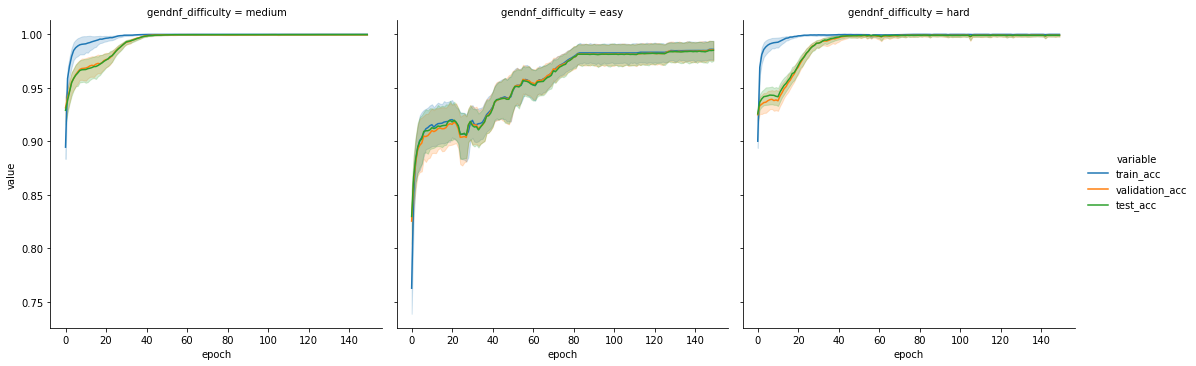

In [8]:
# Plot trainint and test results
df = exp_data
df = df[df['train_type'] == 'deep']
fields = [k for k in df.columns if k.endswith('loss')]
fields = [k for k in exp_data.columns if k.endswith('acc')]
df = df.melt(id_vars=['epoch', 'gendnf_difficulty'], value_vars=fields)
sns.relplot(x='epoch', y='value', hue='variable', kind='line', col='gendnf_difficulty', data=df)
# Plot accuracy
#fields = [k for k in exp_data.columns if k.endswith('acc')]
#plot_data = exp_data.melt(id_vars=['step'], value_vars=fields)
#sns.relplot(x='step', y='value', hue='variable', kind='line', data=plot_data)

## Analyse Run Report
We can pick a single run and analyse the reports such as attention maps and the rules it has learned.

- Look at learnt kernels, prepruning, after pruning and thresholded
- Show the final learnt rule

In [9]:
# For each difficulty pick a random run to analyse
gendnf_difficulty = "easy"
run_ids = exp_data[((exp_data['train_type'] == 'deep') & (exp_data['gendnf_difficulty'] == gendnf_difficulty))]['run_id'].unique()
run_ids

array(['e9e461d2e7474c2d8e473633d75b638b', '358f722877d44bbdbe283ab4991a506a', 'a56ad43507984e458101dcfae1df3890',
       '426fefc36f8843de92bb1c1bf82d14ae', '187790b2a47e4bf19479ebecc72b4769', '0760919fa45b4eabb46298c115aa1ebd',
       'b3cce318f8184c7c8f696e70c5f06481', '38a4965f654c438db3d1d27d52157094', 'a3071c6026214a6887e6ed0e45c1f8bd',
       '476973d91d68491f99a9784bfee1800e', '6b2033df7a364866aba0ba8d667c5b82', 'd9c30d16c52c488b8911603338f4c458',
       'd8aee3a5a38b4fa788239bac6f789de3', '827fef23b24f40c4a31df6316a6d242c', '58e664e3d896407eaad7bb1ef5fa8a95',
       '8df6d10392ca4a998d9687c316ce7756', 'f93b7fca64e546f7b5d14aac3a28f940', '1eabf5c9b07e40eda59a1aeccabced8f',
       '21387d6c818748618265f2a984a7b45f', 'e7404c87185f44d3937135e5a8530291', '2b2415fb09f74ea78055a260ee733352',
       '1b84ef853aa14b5b974e2c2fb74da2d1', 'b3933e7a4dff40c8b29a0b2a8dbd81d4', '37913f330faa4a07b772d5aed895ee1f',
       'c2fcdd96bdd3483cb08a69dfdc111ae0', '80c7c7b10e5d4457b0e52c9b574658c0', '

In [10]:
# Gather a specific run
run_id = "6767afba57c1494c999d2abccca016d2"
run_id = run_ids[0]
print("Collecting artifacts for run:", run_id)
mlrun = mlclient.get_run(run_id)
pprint(mlrun.to_dictionary())
pprint(mlclient.list_artifacts(run_id))

{'data': {'metrics': {'epoch': 149.0,
                      'test_acc': 1.0,
                      'test_loss': 0.001240524579770863,
                      'time': 2.936044216156006,
                      'train_acc': 1.0,
                      'train_dnf_layer/success_threshold': 6.0,
                      'train_loss': 0.0012395427329465747,
                      'validation_acc': 1.0,
                      'validation_loss': 0.0012376784579828382},
          'params': {'config_json': 'data/experiments.json.95464e7ce230490a4098f73cf708ed77',
                     'data_dir': 'data',
                     'dataset_name': 'gendnf',
                     'debug': 'False',
                     'dnf_image_classifier_image_activation': 'relu',
                     'dnf_image_classifier_image_hidden_size': '32',
                     'dnf_image_classifier_image_layer_name': 'RelationsGameImageInput',
                     'dnf_image_classifier_image_with_position': 'False',
                     

In [11]:
# Here is the model summary
print(utils.analysis.load_artifact(run_id, "model_summary.txt", mlclient))

Model: "dnf_rule_learner"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nullary (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
unary (InputLayer)              [(None, 3, 2)]       0                                            
__________________________________________________________________________________________________
binary (InputLayer)             [(None, 3, 2, 2)]    0                                            
__________________________________________________________________________________________________
merge_facts (MergeFacts)        {'nullary': (None, 2 0           nullary[0][0]                    
                                                                 unary[0][0]       

In [30]:
# What was the task?
task_description = utils.analysis.load_artifact(run_id, 'task_description.json', mlclient)
print("Target kernels:")
pprint(task_description['metadata']['and_kernel'])
pprint(task_description['metadata']['or_kernel'])
print("Target rule:")
pprint(task_description['metadata']['rule_str'])

Target kernels:
('[[0, 0, 1, 0, 1, -1, 0, 0, -1, 0], [0, -1, -1, 1, -1, 1, 1, -1, -1, 1], [-1, '
 '-1, 1, 1, 0, -1, -1, 1, -1, 1]]')
'[0, 1, 0]'
Target rule:
['t :- not nullary(1), not unary(V0,0), unary(V0,1), not unary(V1,0), '
 'unary(V1,1), binary(V0,V1,0), not binary(V0,V1,1), not binary(V1,V0,0), '
 'binary(V1,V0,1), obj(V1), V1 != V0, obj(V0).']


In [49]:
# What did the model learn?
pruning_info = utils.analysis.load_artifact(run_id, 'pruning_info.json', mlclient)
for key in ['orig', 'pruned', 'threshold', 'threshold_prune']:
    print(key.upper())
    print(np.array(pruning_info[key+'_and_kernel']))
    print(np.array(pruning_info[key+'_or_kernel']))

ORIG
[[[-1.26842 -6.50709 -6.44987  6.31481 -6.30703  6.31046 -6.01768  6.1082   6.19517 -6.17217]
  [ 4.60548 -5.50474 -5.34646  5.36606 -5.34644  5.36607 -4.54966  4.69026 -4.54933  4.6903 ]
  [-5.17667  4.87751  5.0092  -5.12423  5.0337  -5.01755  4.88126  5.03372 -4.96124 -4.84312]]]
[[12.00612  0.0792   0.05501]]
PRUNED
[[[-0.      -6.50709 -6.44987  6.31481 -6.30703  6.31046 -6.01768  6.1082   6.19517 -6.17217]
  [ 0.      -0.      -0.       0.      -0.       0.      -0.       0.      -0.       0.     ]
  [-0.       0.       0.      -0.       0.      -0.       0.       0.      -0.      -0.     ]]]
[[12.00612  0.       0.     ]]
THRESHOLD
[[[ 0. -6. -6.  6. -6.  6. -6.  6.  6. -6.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]]
[[6. 0. 0.]]
THRESHOLD_PRUNE
[[[ 0. -6. -6.  6. -6.  6. -6.  6.  6. -6.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]]
[[6. 0. 0.]]


In [51]:
# What is the final rule?
print("Final accuracy with following rule is", pruning_info['test_thresholded_pruned_acc'])
test_report = utils.analysis.load_artifact(run_id, 'test_report.npz', mlclient)
# Here we construct an interpretation to get the size of the domain, it is not used in translating the actual rule
interpretation = {k: test_report['in_'+k] for k in ['nullary', 'unary', 'binary']}
rule_kernels = {
    'and_kernel': np.array(pruning_info['threshold_prune_and_kernel'])[0],
    'or_kernel': np.array(pruning_info['threshold_prune_or_kernel'])[0],
    'num_variables': task_description['metadata']['num_variables']
}
pprint(utils.clingo.tensor_rule_to_strings(interpretation, rule_kernels))

Final accuracy with following rule is 1.0
['t :- not nullary(1), not unary(V0,0), not unary(V0,1), not unary(V1,0), not '
 'unary(V1,1), not binary(V0,V1,0), not binary(V0,V1,1), not binary(V1,V0,0), '
 'not binary(V1,V0,1), obj(V1), V1 != V0, obj(V0).']
